# Model 2: Feature extraction with pretrained token embeddings

In [41]:
# Import Libraries

import os
import pickle
import pandas as pd
from helper_functions import calculate_results
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import random
import tensorflow_hub as hub

In [42]:
# Import cleaned Dataset

#clean_dir = '/content/Data/Cleaned_dataset/'
clean_dir = '/content/'

train_df = pd.read_csv(clean_dir + 'train.csv',index_col=False)
val_df = pd.read_csv(clean_dir + 'val.csv',index_col=False)
test_df = pd.read_csv(clean_dir + 'test.csv',index_col=False)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [43]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [44]:
# View first 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [45]:
# One hot encoding labels

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [46]:
# Extract labels ("target" columns) and encode them into integers

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [47]:
# Download pretrained TensorFlow Hub USE

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the embedding on a random sentence

random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")

use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
as intermittent theta burst stimulation ( itbs ) modulates cortical activity , we furthermore investigated its ability to normalise prefrontal activation .

Sentence after embedding:
[ 0.02617016  0.05960659 -0.02231246 -0.02799581 -0.00321958  0.04510986
 -0.04812179 -0.08555354  0.06617858  0.05878348  0.07637136 -0.04365912
  0.06708278  0.07771885  0.01105128 -0.08247124 -0.04950825  0.04119534
  0.06442183  0.00713218 -0.06777554  0.01119947 -0.05039726  0.03129179
  0.04084975  0.06971402 -0.07201406  0.00409673 -0.0663486   0.07150897] (truncated output)...

Length of sentence embedding:
512


In [52]:
# Define feature extractor model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Get a summary of the model
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
# Fit feature extractor model for 3 epochs
model_2_history = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 23ms/step - loss: 0.9177 - accuracy: 0.6566 - val_loss: 0.7976 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 16s 29ms/step - loss: 0.7703 - accuracy: 0.7012 - val_loss: 0.7559 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7540 - accuracy: 0.7105 - val_loss: 0.7414 - val_accuracy: 0.7118


In [55]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7433 - accuracy: 0.7136


[0.7432510256767273, 0.7135906219482422]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[0.42812514, 0.35582617, 0.00236369, 0.20628761, 0.00739748],
       [0.38246912, 0.47380567, 0.00304425, 0.1379166 , 0.00276439],
       [0.22780219, 0.15970175, 0.0160983 , 0.55955267, 0.03684512],
       ...,
       [0.00247557, 0.00610616, 0.06845461, 0.00101952, 0.9219441 ],
       [0.00461334, 0.04656874, 0.18295749, 0.00165107, 0.7642094 ],
       [0.20658857, 0.2841756 , 0.44459346, 0.00796741, 0.05667498]],
      dtype=float32)

In [57]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.35906262412286,
 'precision': 0.7136428102462843,
 'recall': 0.7135906262412286,
 'f1': 0.710529357621437}

<Axes: >

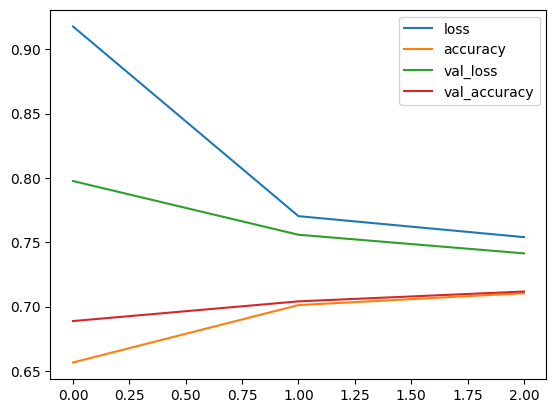

In [59]:
pd.DataFrame(model_2_history.history).plot()

In [60]:
# Export results for later comparison

with open('/content/model_2_results.pickle', 'wb') as f:
    pickle.dump(model_2_results, f)